In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
7,application_1609505959304_0007,pyspark,idle,Link,Link


SparkSession available as 'spark'.

## Import modules

In [2]:
import hashlib
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, LongType
from pyspark.sql.functions import explode
from graphframes import *
import hsfs
from hops import hdfs

## Define utility functions

In [3]:
def action_2_code(x):
    if (x == "CASH_IN"):
        node_type = 0
    elif (x == "CASH_OUT"):
        node_type = 1
    elif (x == "DEBIT"):
        node_type = 2
    elif (x == "PAYMENT"):
        node_type = 3
    elif (x == "TRANSFER"):
        node_type = 4
    elif (x == "DEPOSIT"):
        node_type = 4        
    else:
        node_type = 99
    return node_type

def timestamp_2_time(x):
    dt_obj = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    return dt_obj.timestamp()

action_2_code_udf = F.udf(action_2_code)
timestamp_2_time_udf = F.udf(timestamp_2_time)

In [4]:
def prep_for_plotting(demo_alert,tx_df,motif):
    demo_sources = demo_alert.select("orig_acct").toDF("id")
    demo_targets = demo_alert.select("bene_acct").toDF("id")
    demo_nodes = demo_sources.union(demo_targets).dropDuplicates()
    demo_nodes_array = [int(row.id) for row in demo_nodes.collect()]
    sources = tx_df.select("orig_acct").toDF("id")
    targets = tx_df.select("bene_acct").toDF("id")
    nodes = sources.union(targets).dropDuplicates()
    edges = tx_df.select("orig_acct","bene_acct").toDF("src", "dst")
    # Now lets construct the graph
    g = GraphFrame(nodes, edges)
    max2hop = g.find(motif)
    if motif == "(a)-[ab]->(b); (b)-[bc]->(c)":
        max2hop = max2hop.select('a.*','ab','b.*','bc','c.*').toDF("a","ab","b","bc","c")
        max2hop_from_to_demo_nodes = max2hop.join(
            demo_nodes,
            [(demo_nodes.id==max2hop.a)|(demo_nodes.id==max2hop.b)|(demo_nodes.id==max2hop.c)],
            how="inner"
        )
        e1 = max2hop_from_to_demo_nodes.select("ab").toDF("e")
        e2 = max2hop_from_to_demo_nodes.select("bc").toDF("e")
        e = e1.union(e2).dropDuplicates()        
    elif motif == "(a)-[ab]->(b)":
        max2hop = max2hop.select('a.*','ab','b.*').toDF("a","ab","b")        
        max2hop_from_to_demo_nodes = max2hop.join(
            demo_nodes,
            [(demo_nodes.id==max2hop.a)|(demo_nodes.id==max2hop.b)],
            how="inner"
        )
        e = max2hop_from_to_demo_nodes.select("ab").toDF("e").dropDuplicates()
        
    e = e.select('e.*')
    tx_alerts_labels = transactions_df.select("orig_acct","bene_acct","is_sar")
    e_alerts = e.join(tx_alerts_labels,[(e.src==tx_alerts_labels.orig_acct)&(e.dst==tx_alerts_labels.bene_acct)],how="left").drop("orig_acct","bene_acct")
    return demo_nodes, e_alerts

In [5]:
simname = "10K_all_5_01_720"

## Load accounts datasets as spark dataframe and perform feature engineering

In [6]:
accounts_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/accounts.csv".format(hdfs.project_name(),simname))

accounts_df = accounts_df.drop('first_name')\
                         .drop('last_name')\
                         .drop('street_addr')\
                         .drop('city')\
                         .drop('state')\
                         .drop('zip')\
                         .drop('gender')\
                         .drop('birth_date')\
                         .drop('ssn')\
                         .drop('lon')\
                         .drop('lat')

In [7]:
accounts_df = accounts_df.withColumn('prior_sar',F.when(F.col('prior_sar_count') == 'true', 1).otherwise(0))\
                         .drop("prior_sar_count","acct_rptng_crncy","type","acct_stat","open_dt","bank_id","country","close_dt","dsply_nm","branch_id")

In [8]:
accounts_df.show()

+-------+---------------+--------------+---------+
|acct_id|initial_deposit|tx_behavior_id|prior_sar|
+-------+---------------+--------------+---------+
|      0|       81145.08|             1|        0|
|      1|       87089.35|             1|        0|
|      2|       89759.68|             1|        0|
|      3|       97122.51|             1|        0|
|      4|       86994.93|             1|        0|
|      5|       96116.25|             1|        0|
|      6|       51450.26|             1|        0|
|      7|       73281.13|             1|        1|
|      8|       97167.84|             1|        1|
|      9|       82448.73|             1|        0|
|     10|       95045.02|             1|        0|
|     11|        55660.3|             1|        0|
|     12|       73453.45|             1|        0|
|     13|       62328.64|             1|        0|
|     14|       77188.04|             1|        0|
|     15|       78697.06|             1|        0|
|     16|       50655.71|      

In [9]:
accounts_df.select("tx_behavior_id").dropDuplicates().show()

+--------------+
|tx_behavior_id|
+--------------+
|             1|
|             3|
|             5|
|             4|
|             2|
+--------------+

## Load transactions datasets as spark dataframe and perform feature engineering

In [10]:
transactions_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/transactions.csv".format(hdfs.project_name(),simname))

transactions_df.show()

+-------+---------+---------+-------------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|            tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+-------------------+--------+-------------------+------+--------+
|      1|     9098|     9960|TRANSFER-Periodical|  920.64|2020-01-01 00:00:00| false|      -1|
|      2|     5338|     6016|    TRANSFER-Mutual|  848.67|2020-01-01 00:00:00| false|      -1|
|      3|      150|     4748|    TRANSFER-FanOut|  247.73|2020-01-01 00:00:00| false|      -1|
|      4|     6575|     8880|   TRANSFER-Forward|  518.15|2020-01-01 00:00:00| false|      -1|
|      5|     6515|     3613|   TRANSFER-Forward|  389.94|2020-01-01 00:00:00| false|      -1|
|      6|     8859|     9123|TRANSFER-Periodical|  834.62|2020-01-01 00:00:00| false|      -1|
|      7|      930|     9263|    TRANSFER-FanOut|  210.54|2020-01-01 00:00:00| false|      -1|
|      8|      737|     2907|    TRANSFER-FanOut| 

In [11]:
alert_accounts_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/alert_accounts.csv".format(hdfs.project_name(),simname))

alert_accounts_df.show()
#alert_accounts_df.orderBy("alert_id").show()

+--------+--------------+-------+---------+------+--------+-----+-------+-----------+-------+
|alert_id|    alert_type|acct_id|acct_name|is_sar|model_id|start|    end|schedule_id|bank_id|
+--------+--------------+-------+---------+------+--------+-----+-------+-----------+-------+
|       0|scatter_gather|   6542|     6542|  true|       7|    0|1000000|          0|   bank|
|       0|scatter_gather|    442|      442|  true|       7|    0|1000000|          0|   bank|
|       0|scatter_gather|   1073|     1073|  true|       7|    0|1000000|          0|   bank|
|       0|scatter_gather|   3376|     3376|  true|       7|    0|1000000|          0|   bank|
|       0|scatter_gather|   5125|     5125|  true|       7|    0|1000000|          0|   bank|
|       0|scatter_gather|   8674|     8674|  true|       7|    0|1000000|          0|   bank|
|       0|scatter_gather|   1198|     1198|  true|       7|    0|1000000|          0|   bank|
|       1|scatter_gather|   5363|     5363|  true|       7| 

In [12]:
alert_accounts_df.count()

816

In [13]:
alert_transactions_df = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/alert_transactions.csv".format(hdfs.project_name(),simname))
alert_transactions_df.orderBy("alert_id").show()

+--------+--------------+------+-------+---------+---------+-------------------+--------+-------------------+
|alert_id|    alert_type|is_sar|tran_id|orig_acct|bene_acct|            tx_type|base_amt|     tran_timestamp|
+--------+--------------+------+-------+---------+---------+-------------------+--------+-------------------+
|       0|scatter_gather|  true| 412755|     6542|     8674|   TRANSFER-Forward| 2703.12|2020-10-15 00:00:00|
|       0|scatter_gather|  true| 415216|     6542|     1198|   TRANSFER-Forward| 2703.12|2020-10-17 00:00:00|
|       0|scatter_gather|  true| 417646|     5125|      442|    TRANSFER-Mutual| 2432.82|2020-10-19 00:00:00|
|       0|scatter_gather|  true| 409366|     6542|     3376|   TRANSFER-Forward| 2703.12|2020-10-13 00:00:00|
|       0|scatter_gather|  true| 420418|     3376|      442|     TRANSFER-FanIn| 2432.82|2020-10-21 00:00:00|
|       0|scatter_gather|  true| 423738|     8674|      442|TRANSFER-Periodical| 2432.82|2020-10-23 00:00:00|
|       0|

In [14]:
alert_transactions_df.count()

915

In [15]:
alert_acct_id_df = alert_accounts_df.select("acct_id")
alert_related_transactions_df = transactions_df.join(
    alert_acct_id_df,
    [(alert_acct_id_df.acct_id==transactions_df.orig_acct)|(alert_acct_id_df.acct_id==transactions_df.bene_acct)],
    how="inner"
).dropDuplicates(subset=['tran_id']).drop("acct_id")
alert_related_transactions_df.show()

+-------+---------+---------+-------------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|            tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+-------------------+--------+-------------------+------+--------+
|   1829|      522|      721|    TRANSFER-FanOut|  793.85|2020-01-02 00:00:00| false|      -1|
|   2122|     7345|     5491|   TRANSFER-Forward|  605.49|2020-01-02 00:00:00| false|      -1|
|   4900|     4961|     3473|    TRANSFER-Mutual|  343.97|2020-01-04 00:00:00| false|      -1|
|   7253|     9911|     9267|TRANSFER-Periodical|  611.42|2020-01-06 00:00:00| false|      -1|
|   9427|      748|     2277|    TRANSFER-FanOut|  927.95|2020-01-07 00:00:00| false|      -1|
|   9465|     1534|     5305|    TRANSFER-FanOut|  114.54|2020-01-07 00:00:00| false|      -1|
|  10206|     7590|     8236|   TRANSFER-Forward|  750.35|2020-01-08 00:00:00| false|      -1|
|  10623|     8664|     4525|TRANSFER-Periodical| 

In [16]:
alert_related_transactions_df.count()

162329

In [17]:
alert_related_transactions_df.where(F.col("alert_id")==-1).show()

+-------+---------+---------+-------------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|            tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+-------------------+--------+-------------------+------+--------+
|   1829|      522|      721|    TRANSFER-FanOut|  793.85|2020-01-02 00:00:00| false|      -1|
|   2122|     7345|     5491|   TRANSFER-Forward|  605.49|2020-01-02 00:00:00| false|      -1|
|   4900|     4961|     3473|    TRANSFER-Mutual|  343.97|2020-01-04 00:00:00| false|      -1|
|   7253|     9911|     9267|TRANSFER-Periodical|  611.42|2020-01-06 00:00:00| false|      -1|
|   9427|      748|     2277|    TRANSFER-FanOut|  927.95|2020-01-07 00:00:00| false|      -1|
|   9465|     1534|     5305|    TRANSFER-FanOut|  114.54|2020-01-07 00:00:00| false|      -1|
|  10206|     7590|     8236|   TRANSFER-Forward|  750.35|2020-01-08 00:00:00| false|      -1|
|  10623|     8664|     4525|TRANSFER-Periodical| 

## now select all nodes, sar and non sar that are related to alerts

In [18]:
alert_related_sources = alert_related_transactions_df.select("orig_acct").toDF("id")
alert_related_targets = alert_related_transactions_df.select("bene_acct").toDF("id")
alert_related_nodes = alert_related_sources.union(alert_related_targets).dropDuplicates()
alert_related_transactions_df = transactions_df.join(
    alert_related_nodes,
    [(alert_related_nodes.id==transactions_df.orig_acct)|(alert_related_nodes.id==transactions_df.bene_acct)],
    how="inner"
).dropDuplicates(subset=['tran_id']).drop("acct_id")
alert_related_transactions_df.count()

740775

In [22]:
alert_transactions_df\
   .repartition(1)\
   .write\
   .format("csv")\
   .option("header", "true")\
   .save("hdfs:///Projects/{}/Resources/{}_alert_transactions_df.csv".format(hdfs.project_name(),simname))

In [19]:
alert_related_transactions_df\
   .repartition(1)\
   .write\
   .format("csv")\
   .option("header", "true")\
   .save("hdfs:///Projects/{}/Resources/{}_alert_related_transactions_df.csv".format(hdfs.project_name(),simname))

In [ ]:
non_alert_related_transactions_df = transactions_df.join(
    alert_related_nodes,
    [(alert_related_nodes.id==transactions_df.orig_acct)|(alert_related_nodes.id==transactions_df.bene_acct)],
    how="leftanti"
).dropDuplicates(subset=['tran_id']).drop("acct_id")
non_alert_related_transactions_df.count()

289008

In [ ]:
non_alert_related_transactions_df\
   .repartition(1)\
   .write\
   .format("csv")\
   .option("header", "true")\
   .save("hdfs:///Projects/{}/Resources/{}_non_alert_related_transactions_df.csv".format(hdfs.project_name(),simname))

In [ ]:
transactions_df.count()

1029783

In [24]:
individuals = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/individuals-bulkload.csv".format(hdfs.project_name(),simname))\
             .select("partyId","partyType")
 
organizations = spark.read\
             .option("inferSchema", "true")\
             .option("header", "true")\
             .format("csv")\
             .load("hdfs:///Projects/{}/Resources/{}/organizations-bulkload.csv".format(hdfs.project_name(),simname))\
             .select("partyId","partyType")

party = individuals.union(organizations)

In [25]:
party.show()

+-------+----------+
|partyId| partyType|
+-------+----------+
|      1|Individual|
|      2|Individual|
|      3|Individual|
|      6|Individual|
|      8|Individual|
|     10|Individual|
|     11|Individual|
|     14|Individual|
|     15|Individual|
|     17|Individual|
|     18|Individual|
|     19|Individual|
|     21|Individual|
|     23|Individual|
|     28|Individual|
|     30|Individual|
|     31|Individual|
|     37|Individual|
|     39|Individual|
|     40|Individual|
+-------+----------+
only showing top 20 rows

In [26]:
party.repartition(1)\
   .write\
   .format("csv")\
   .option("header", "true")\
   .save("hdfs:///Projects/{}/Resources/{}_party.csv".format(hdfs.project_name(),simname))

In [ ]:
alert_related_transactions_df.show()

In [ ]:
non_alert_related_transactions_df.show()

In [ ]:
non_alert_related_transactions_df.where(F.col("alert_id")>-1).show()

In [ ]:
alert_transactions_df.where(F.col("alert_type")=="cycle").show()

In [ ]:
alert_transactions_df.where(F.col("alert_id")==89).orderBy("tran_id").show()

In [71]:
demo_alert = alert_transactions_df.where(F.col("alert_id")==89).select("tran_id","orig_acct","bene_acct","base_amt")
demo_alert.show()

+-------+---------+---------+--------+
|tran_id|orig_acct|bene_acct|base_amt|
+-------+---------+---------+--------+
|  10758|     6010|     8188|  154.91|
|  11442|     5688|      246|  139.42|
|  11443|      246|     5552|  125.48|
|  16425|     5332|     5688|  112.93|
|  24569|     5552|     6010|  101.64|
|  26557|     8188|     5332|   91.48|
+-------+---------+---------+--------+

In [33]:
%%spark -o demo_alert

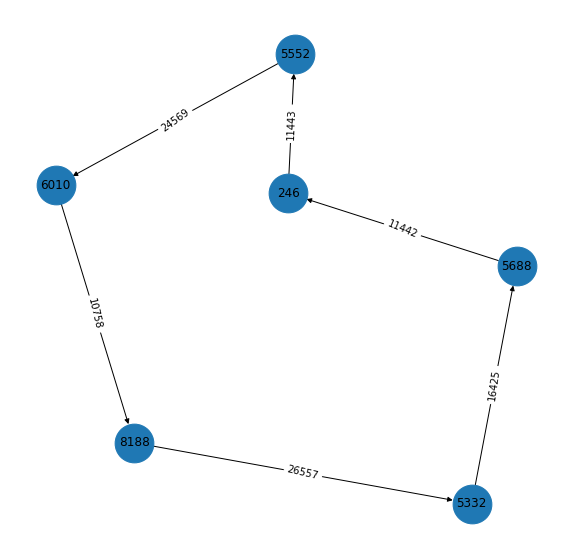

In [34]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

G = nx.from_pandas_edgelist(demo_alert,source='orig_acct',
                                   target='bene_acct',edge_attr=True,
                                   create_using=nx.DiGraph())

val_map = {}

values = [val_map.get(node, 0.45) for node in G.nodes()]
edge_labels=dict([((u,v,),d['tran_id']) for u,v,d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=1500, edge_color=edge_colors,edge_cmap=plt.cm.Reds, with_labels = True) #node_color = values,
plt.show()

In [63]:
#demo_nodes, e_alerts = prep_for_plotting(demo_alert=demo_alert,tx_df=alert_related_transactions_df,motif="(a)-[ab]->(b); (b)-[bc]->(c)")
demo_nodes, e_alerts = prep_for_plotting(demo_alert=demo_alert,tx_df=alert_related_transactions_df,motif="(a)-[ab]->(b)")

In [64]:
%%spark -o e_alerts

In [65]:
%%spark -o demo_nodes

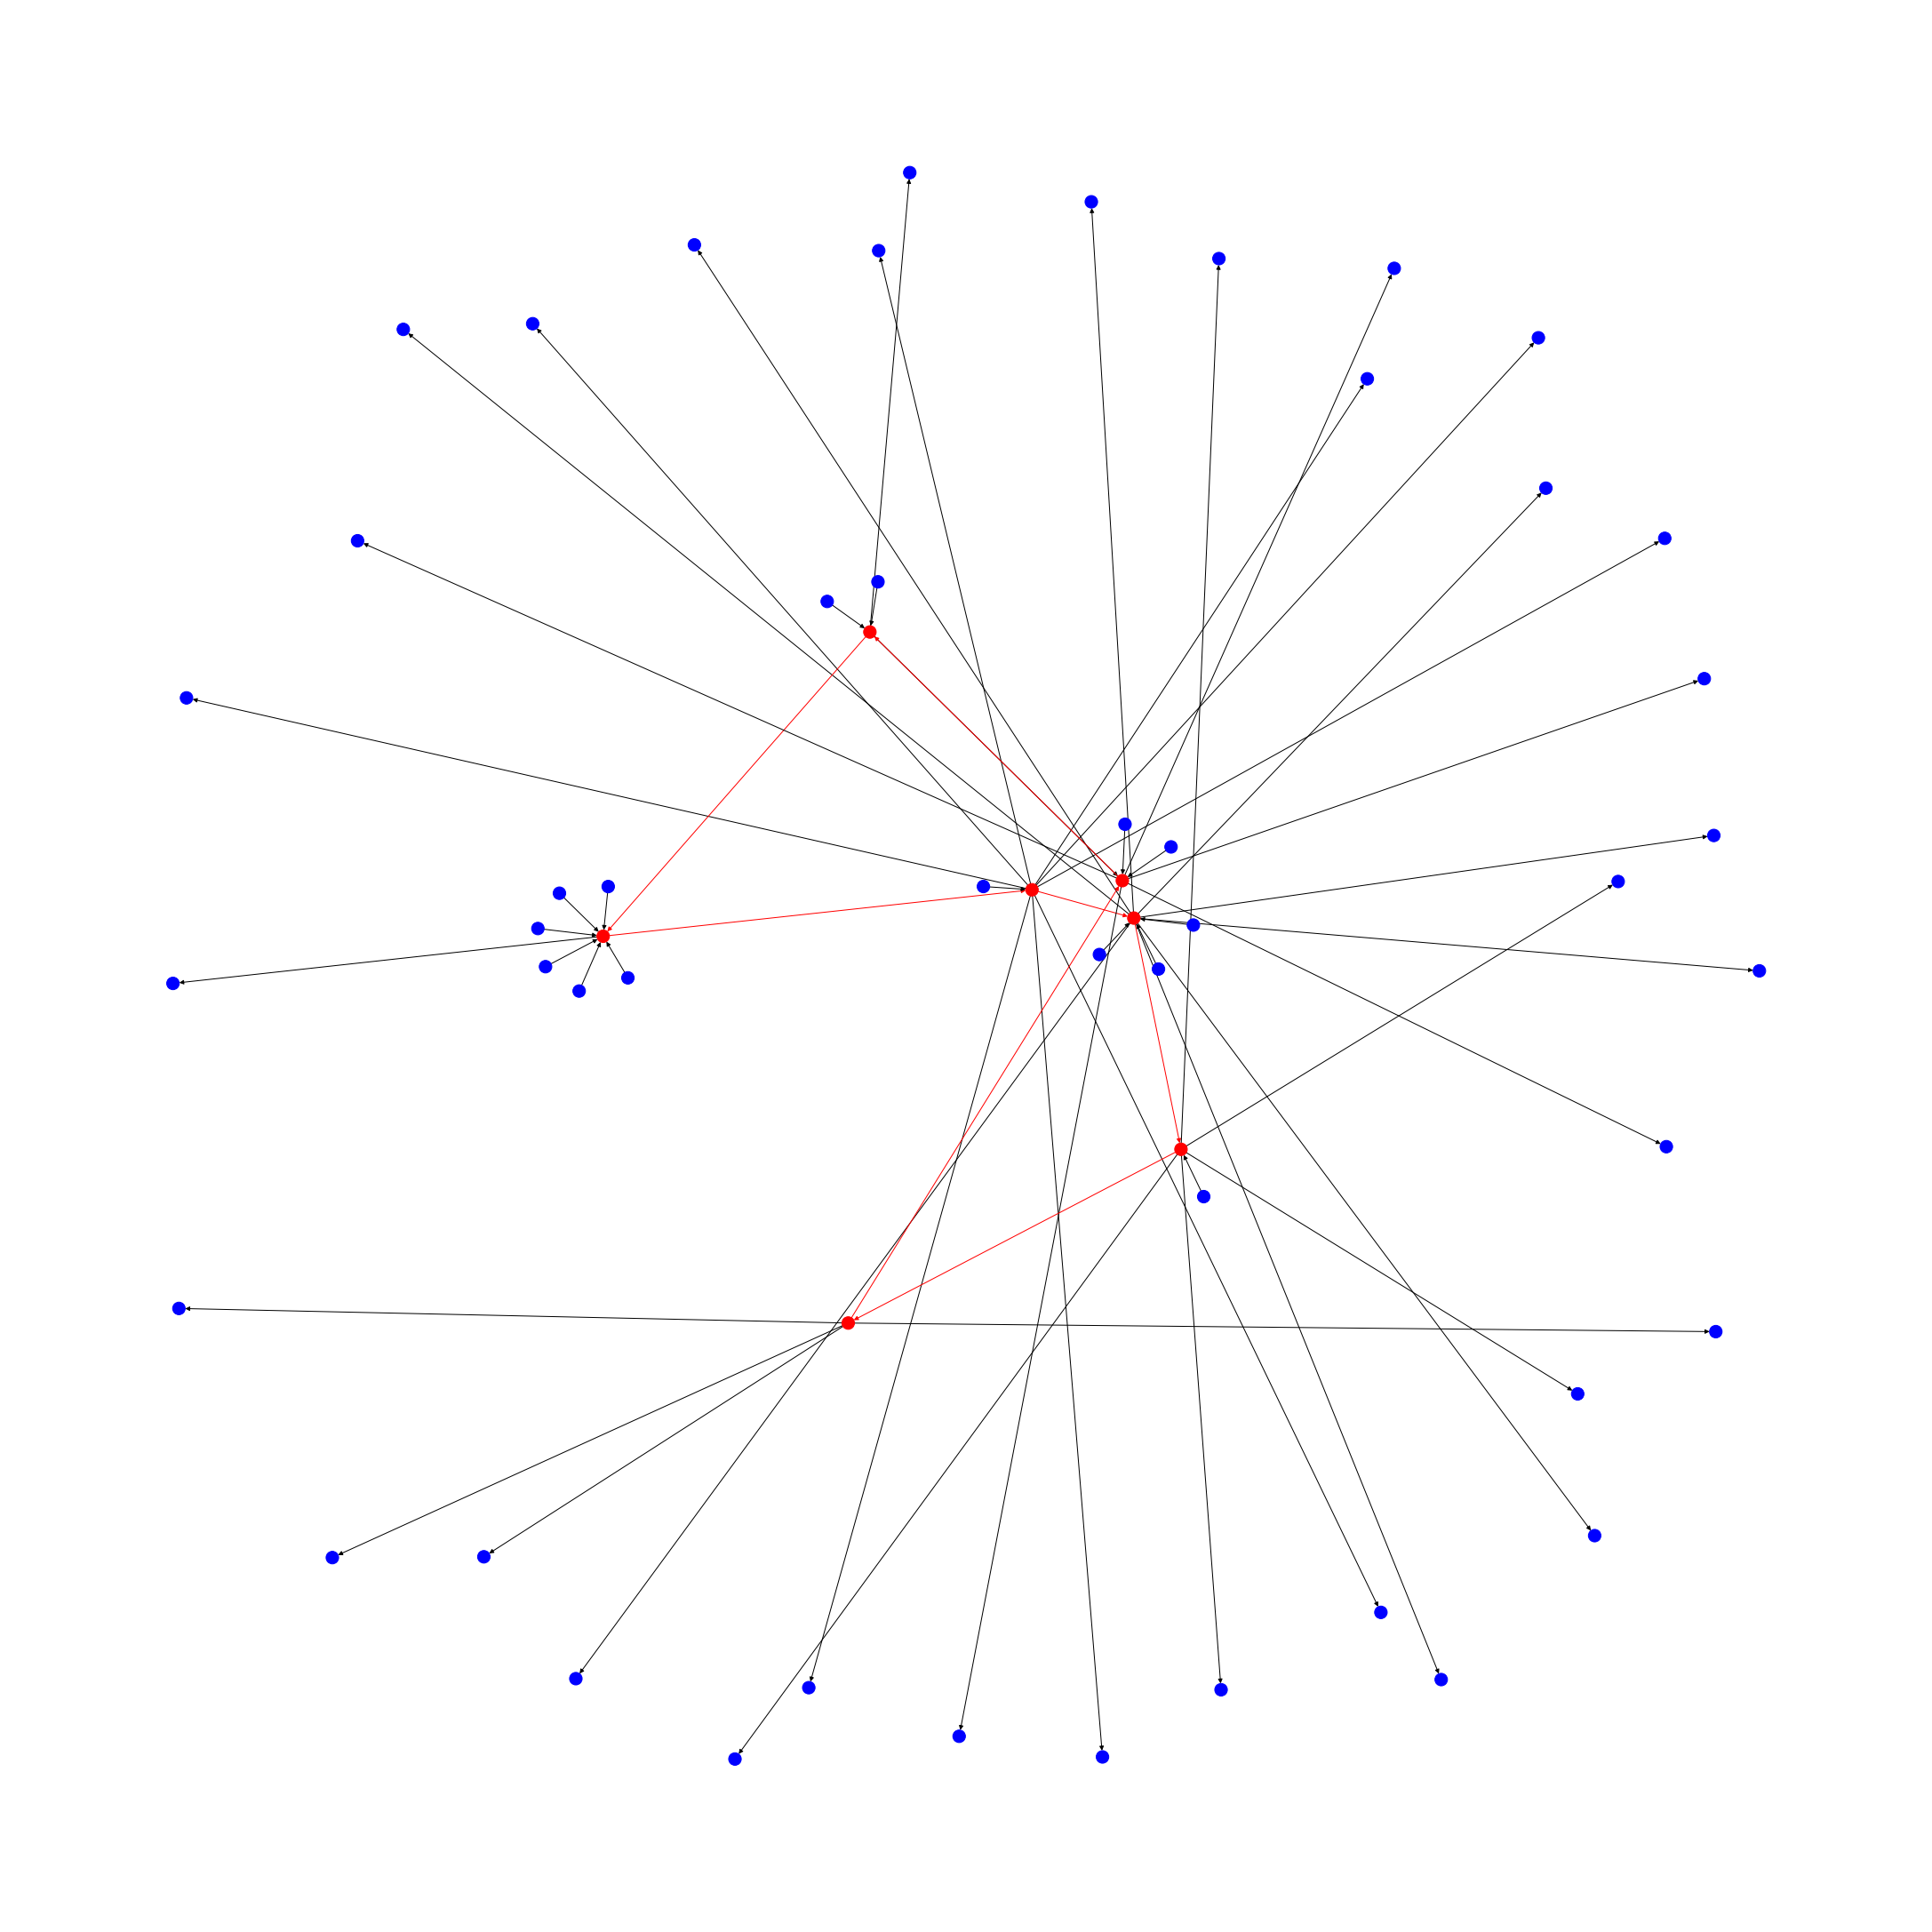

In [66]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
#e.head()
G = nx.from_pandas_edgelist(e_alerts,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

val_map = {19241:1200, 16207:800}

values = [val_map.get(node, 200) for node in G.nodes()]

#edge_labels=dict([((u,v,),d['tran_id']) for u,v,d in G.edges(data=True)])
red_edges = [(u,v,) for u,v,d in G.edges(data=True) if d['is_sar']==True ]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]
node_colors = ['blue' if not node in list(sum(red_edges, ())) else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color=edge_colors,edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()

In [71]:
non_alert_related_transactions_df.show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    148|    18881|     3076|TRANSFER-FanOut|  972.76|2020-01-01 00:00:00| false|      -1|
|    463|    19195|     2588|TRANSFER-FanOut|  590.17|2020-01-01 00:00:00| false|      -1|
|    471|     9896|     3998|TRANSFER-FanOut|  632.81|2020-01-01 00:00:00| false|      -1|
|   1238|     8751|     4701|TRANSFER-FanOut|  194.26|2020-01-01 00:00:00| false|      -1|
|   1342|     8661|    19826|TRANSFER-FanOut|  115.78|2020-01-01 00:00:00| false|      -1|
|   1580|     3637|     4171|TRANSFER-FanOut|  958.31|2020-01-01 00:00:00| false|      -1|
|   1591|     9261|     8762|TRANSFER-FanOut|   415.0|2020-01-01 00:00:00| false|      -1|
|   1645|     8979|     8966|TRANSFER-FanOut|  407.84|2020-01-01 00:00:00| false|      -1|

In [47]:
demo = non_alert_related_transactions_df.where(F.col("orig_acct")==18881)
demo.orderBy('tran_id').show()

+-------+---------+---------+---------------+--------+-------------------+------+--------+
|tran_id|orig_acct|bene_acct|        tx_type|base_amt|     tran_timestamp|is_sar|alert_id|
+-------+---------+---------+---------------+--------+-------------------+------+--------+
|    148|    18881|     3076|TRANSFER-FanOut|  972.76|2020-01-01 00:00:00| false|      -1|
|  22372|    18881|      349|TRANSFER-FanOut|  681.15|2020-01-08 00:00:00| false|      -1|
|  60321|    18881|    10386|TRANSFER-FanOut|  559.66|2020-01-22 00:00:00| false|      -1|
|  81539|    18881|    12823|TRANSFER-FanOut|  547.94|2020-01-29 00:00:00| false|      -1|
| 101496|    18881|     3170|TRANSFER-FanOut| 1008.21|2020-02-05 00:00:00| false|      -1|
| 122140|    18881|    12059|TRANSFER-FanOut|  341.63|2020-02-12 00:00:00| false|      -1|
| 142546|    18881|     5430|TRANSFER-FanOut|  270.05|2020-02-19 00:00:00| false|      -1|
| 163068|    18881|    16245|TRANSFER-FanOut|  691.85|2020-02-26 00:00:00| false|      -1|

In [40]:
demo_nodes, e_alerts = prep_for_plotting(demo_alert=demo,tx_df=non_alert_related_transactions_df,motif="(a)-[ab]->(b)")

In [41]:
e_alerts.count()

126

In [42]:
demo_nodes.count()

9

In [43]:
%%spark -o e_alerts

In [44]:
%%spark -o demo_nodes

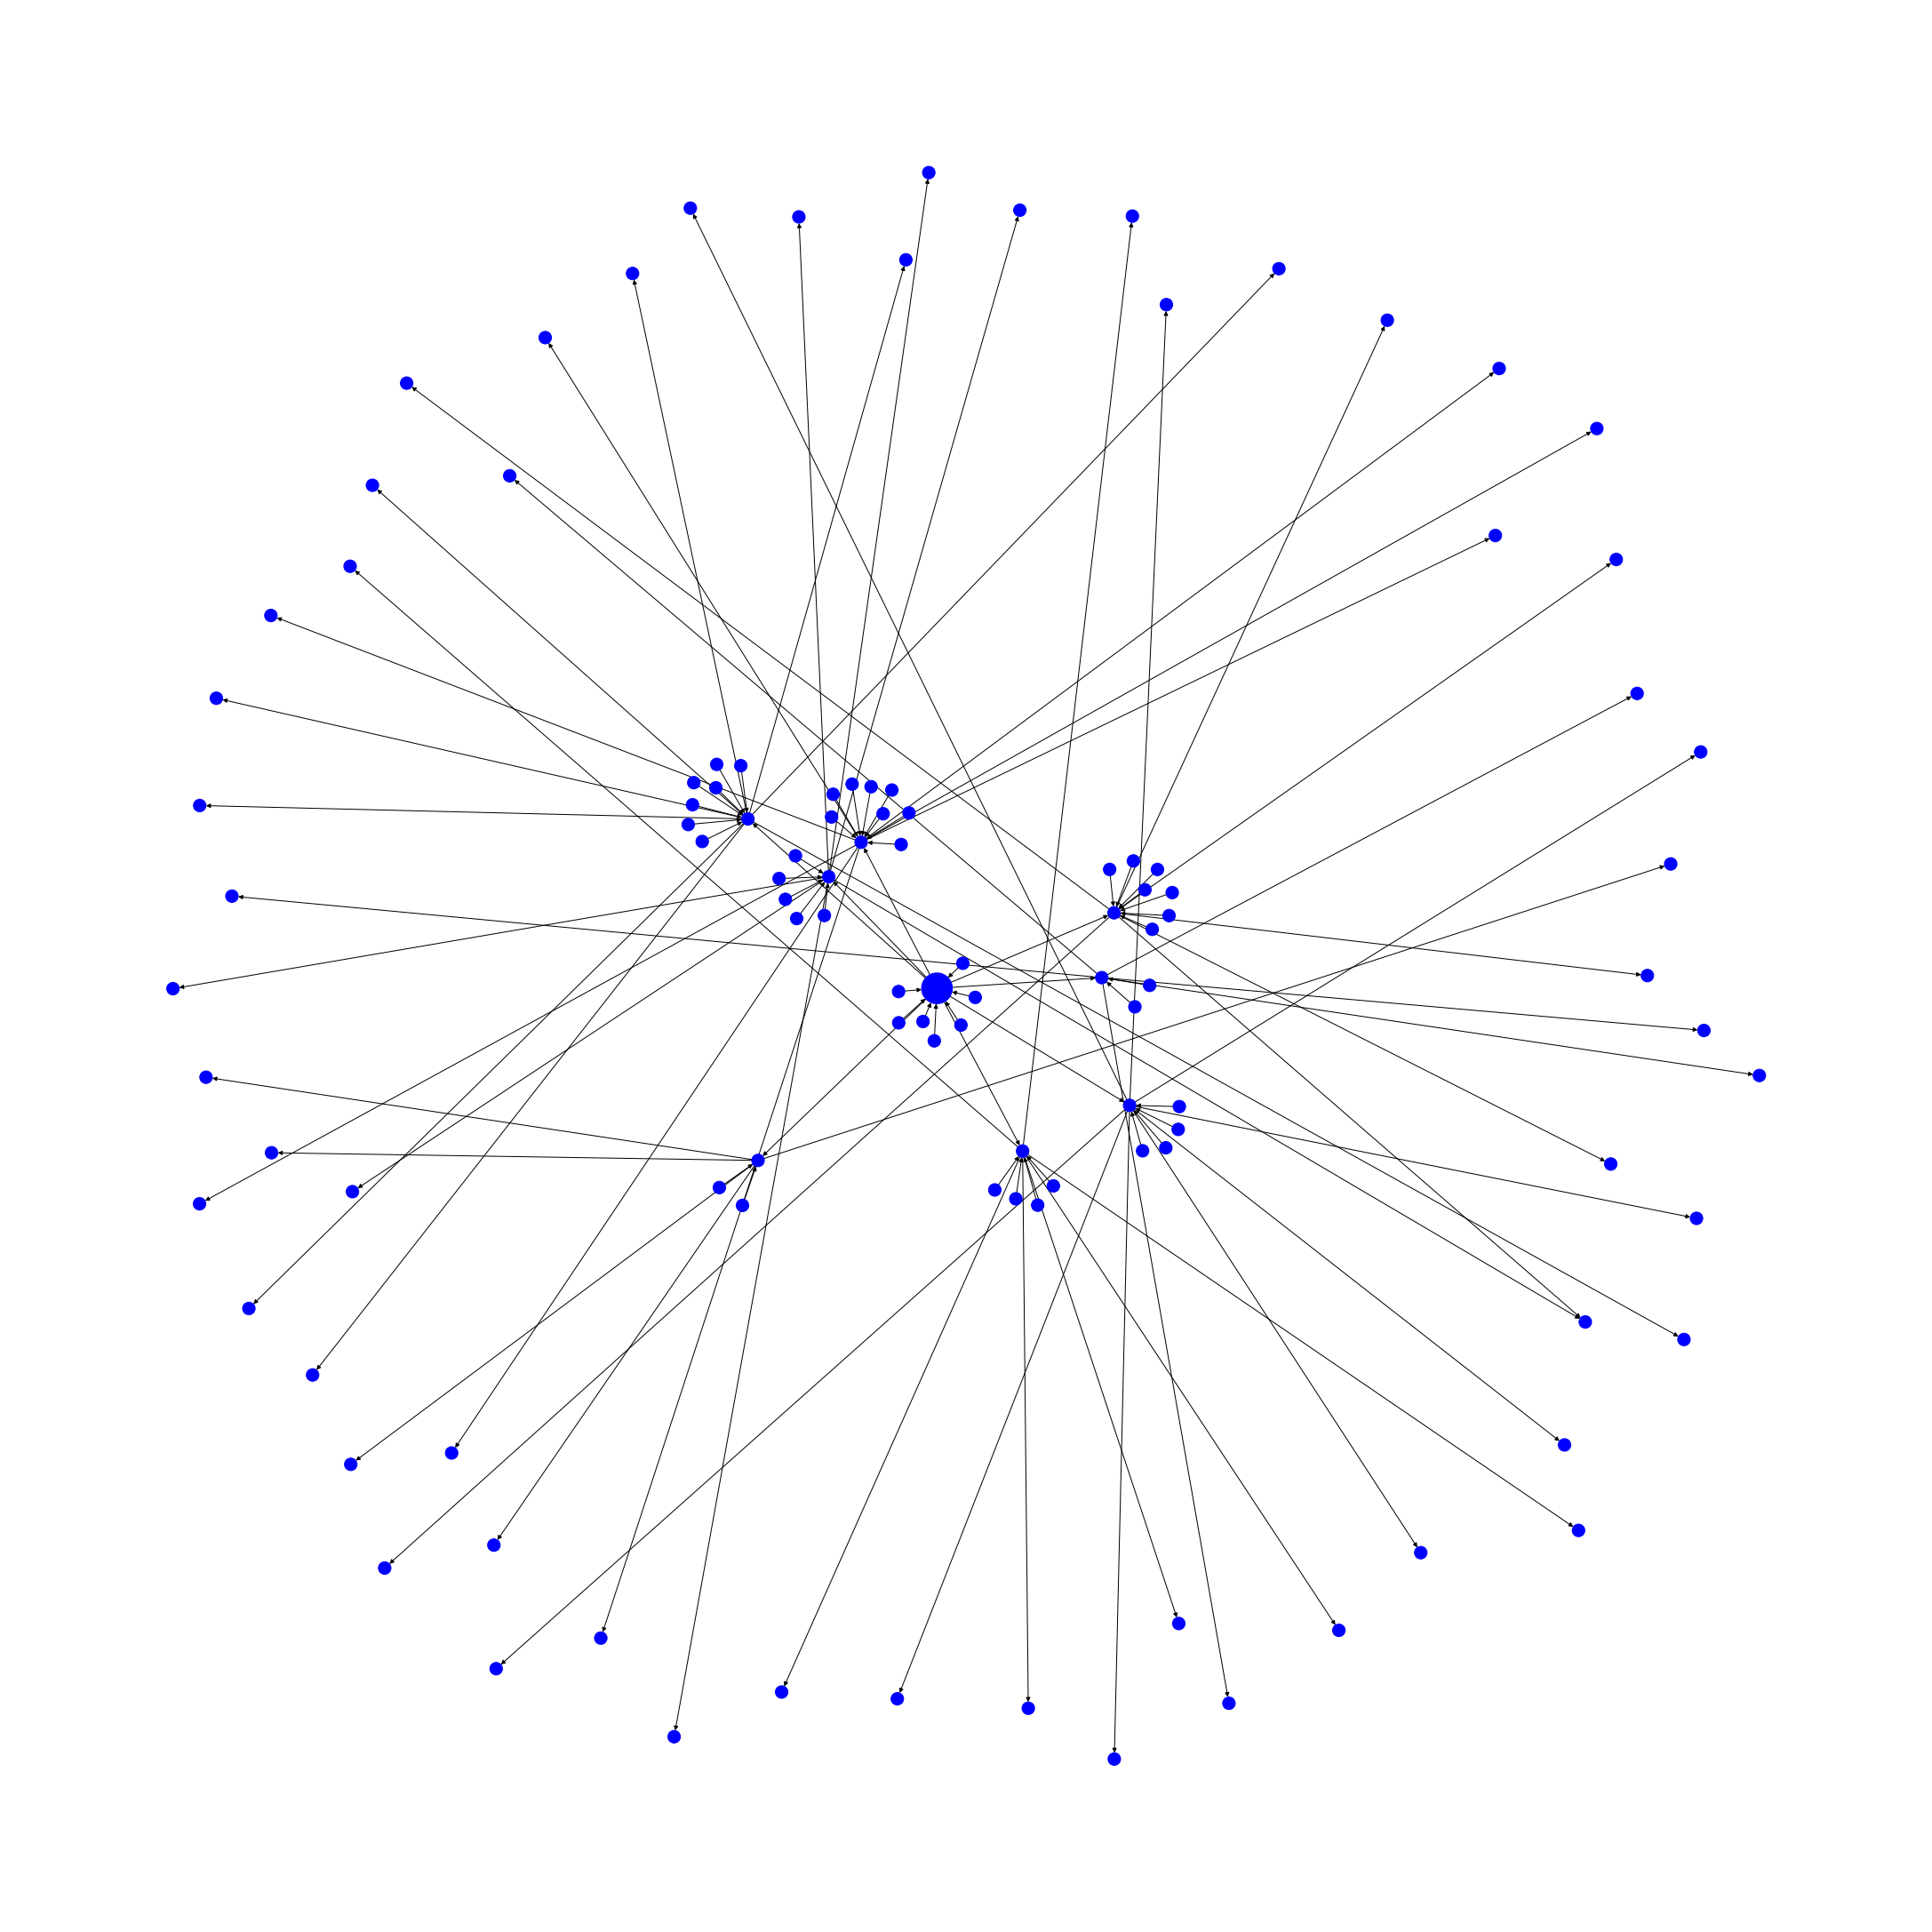

In [45]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
#e.head()
G = nx.from_pandas_edgelist(e_alerts,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

val_map = {18881:1200}

values = [val_map.get(node, 200) for node in G.nodes()]

#edge_labels=dict([((u,v,),d['tran_id']) for u,v,d in G.edges(data=True)])
red_edges = [(u,v,) for u,v,d in G.edges(data=True) if d['is_sar']==True ]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]
node_colors = ['blue' if not node in list(sum(red_edges, ())) else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color=edge_colors,edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()

## Create a connection to Hopsworks feature store (hsfs)

In [ ]:
# Create a connection
connection = hsfs.connection()
# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

## Create accounts feature group metadata and save it in to hsfs 

In [ ]:
accounts_fg = fs.create_feature_group(name="account_features",
                                      version=1,
                                      primary_key=["acct_id"],
                                      description="node features",
                                      time_travel_format=None,
                                      statistics_config=False)
accounts_fg.save(accounts_df)

## Create transactions feature group metadata and save it in to hsfs 

In [10]:
transactions_fg = fs.create_feature_group(name="transactions_fg",
                                       version=1,
                                       primary_key=["tran_id"],
                                       description="edge features",
                                       time_travel_format=None,                                        
                                       statistics_config=False)
transactions_fg.save(transactions_df)